# Comparison of $\Delta w$ per weight update in BP and BTSP networks

## 0. Setup

In [1]:
import torch
from torch.utils.data import DataLoader
from pprint import pprint
import matplotlib.pyplot as plt

from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt

pt.update_plot_defaults()

input_size = 21
dataset = torch.eye(input_size) #each row is a different pattern
target = torch.eye(dataset.shape[0])

data_seed = 0
data_generator = torch.Generator()
sample_indexes = torch.arange(len(dataset))
dataloader = DataLoader(list(zip(sample_indexes, dataset, target)), 
                        shuffle=True, 
                        generator=data_generator)

test_dataloader = DataLoader(list(zip(sample_indexes, dataset, target)), 
                             batch_size = 21)
epochs=50
seed=42

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


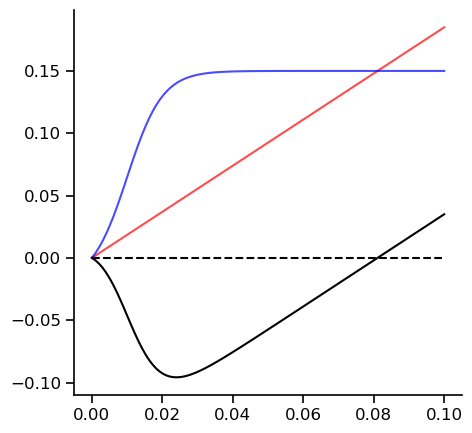

In [129]:
fig = plt.figure(figsize=[5,5])
wmax = 2
w = 0.15
sigm = ut.get_scaled_rectified_sigmoid(0.01,0.02)
e = torch.linspace(0,0.1,100)
dw_pot = e*(wmax-w)
dw_dep = w*sigm(e)
dw = dw_pot - dw_dep

plt.plot(e,dw_pot,color='r',alpha=0.7)
plt.plot(e,dw_dep,color='b',alpha=0.7)
plt.plot(e,dw,c='k')
plt.plot([0,0.1],[0,0],'--',c='k')
plt.legend()
plt.show()
fig.savefig('btsp_equation_curves_high.svg',dpi=300)

In [ ]:
wmax = 2
w = 0.1
sigm1 = ut.get_scaled_rectified_sigmoid(0.01,0.6)
sigm2 = ut.get_scaled_rectified_sigmoid(0.4,0.5)
e = torch.linspace(0,1,20)
dw_pot = e
dw_dep = sigm2(e)
dw = dw_pot - dw_dep

plt.plot(e,dw_pot,color='r')
plt.plot(e,dw_dep,color='b')
plt.plot(e,dw,c='k')
plt.show()

## 1. Create networks

### Regular Backprop (no inh, no weight contraints)

Network: appending a projection from Input E -> H1 E
Network: appending a projection from H1 E -> Output E


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

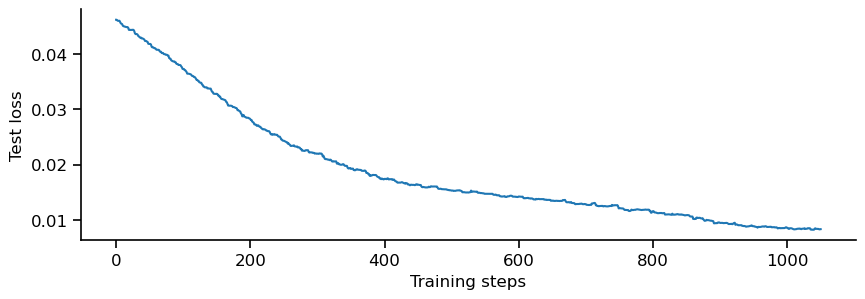

In [2]:
network_config = ut.read_from_yaml('../config/deltaW_analysis/EIANN_1_hidden_vanilla_backprop_softplus_SGD_config.yaml')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)


data_generator.manual_seed(data_seed)
bp_network.train(dataloader, epochs, store_history=True, store_params=True, status_bar=True)

#Swap to ReLU activation to make loss comparable across networks
for layer in bp_network: 
    for population in layer:
        population.activation = torch.nn.ReLU()

bp_network.reset_history()
pt.plot_test_loss_history(bp_network, test_dataloader)

### Dale's Law Backprop (1 inh)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

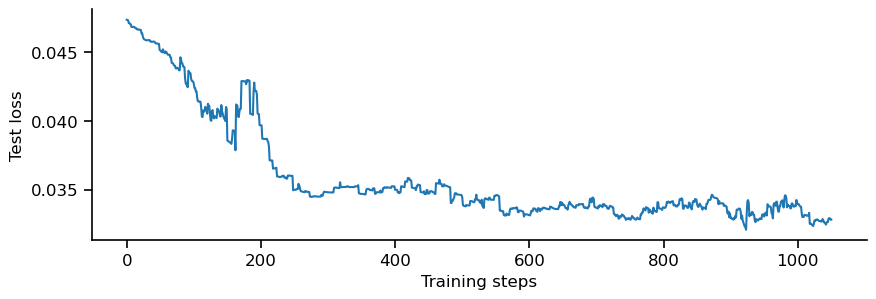

In [3]:
network_config = ut.read_from_yaml('../config/deltaW_analysis/EIANN_1_hidden_backpropDale_1_inh_softplus_SGD_config_B.yaml')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bpDale_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

data_generator.manual_seed(data_seed)
bpDale_network.train(dataloader, epochs, store_history=True, store_params=True, status_bar=True)

for layer in bpDale_network: #swap to ReLU activation to make loss comparable across networks
    for population in layer:
        population.activation = torch.nn.ReLU()

bpDale_network.reset_history()
pt.plot_test_loss_history(bpDale_network, test_dataloader)

### BTSP (1 inh)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

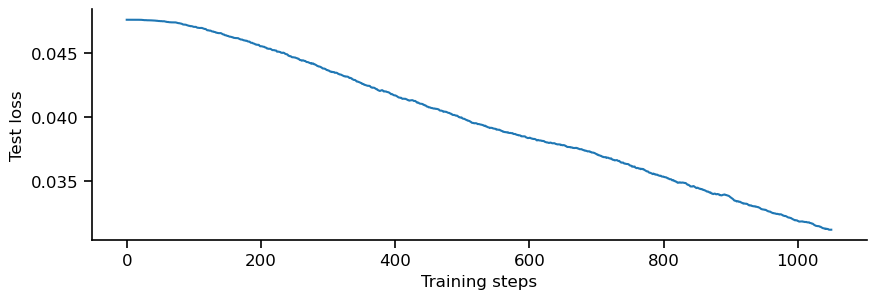

In [4]:
# network_config = ut.read_from_yaml('../optimize/data/20200830_EIANN_1_hidden_BTSP_config_A.yaml')
network_config = ut.read_from_yaml('../config/deltaW_analysis/EIANN_1_hidden_BTSP_config_A.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

data_generator.manual_seed(data_seed)
btsp_network.train(dataloader, epochs, store_history=True, store_params=True, status_bar=True)

btsp_network.reset_history()
pt.plot_test_loss_history(btsp_network, test_dataloader)

## 2. Analyse $\Delta w$ distributions 

In [5]:
#for each unit, extract the (sign of) unit loss/plateau history (not just the global loss)
#https://stackoverflow.com/questions/45988168/why-does-autograd-not-produce-gradient-for-intermediate-variables

# for layer in btsp_network:
#     for population in layer:
#         for projection in population:
#             dW_history = torch.diff(projection.weight_history)
#             for plateau_vec,dW_mat in zip(population.plateau_history, dW_history):
#                 dW_positive['btsp'].append(dW_mat[torch.where(plateau_vec>0)].flatten())
#                 dW_negative['btsp'].append(dW_mat[torch.where(plateau_vec<0)].flatten())

In [6]:
dParam_history_dict = {'bp': ut.get_update_history(bp_network),
                       'bpDale': ut.get_update_history(bpDale_network),
                       'btsp': ut.get_update_history(btsp_network)}

dW_positive = {'bp': [],
               'bpDale': [],
               'btsp': []}

dW_negative = {'bp': [],
               'bpDale': [],
               'btsp': []}

for network_name, dParam_history in dParam_history_dict.items():
    for param_name in dParam_history:
        if "weight" in param_name:
            for dW in dParam_history[param_name]:
                for post_unit_updates in dW:
                    largest_idx = torch.argmax(torch.abs(post_unit_updates))
                    if torch.sign(post_unit_updates[largest_idx])>0:
                        dW_positive[network_name].append(post_unit_updates)
                    elif torch.sign(post_unit_updates[largest_idx])<0:
                        dW_negative[network_name].append(post_unit_updates)
                 
for network_name in dW_positive:
    dW_positive[network_name] = torch.cat(dW_positive[network_name])
    dW_negative[network_name] = torch.cat(dW_negative[network_name])
    
    #Remove zero-updates
    nonzero_idx = torch.where(dW_positive[network_name]!=0)[0]
    dW_positive[network_name] = dW_positive[network_name][nonzero_idx]
    nonzero_idx = torch.where(dW_negative[network_name]!=0)[0]
    dW_negative[network_name] = dW_negative[network_name][nonzero_idx]

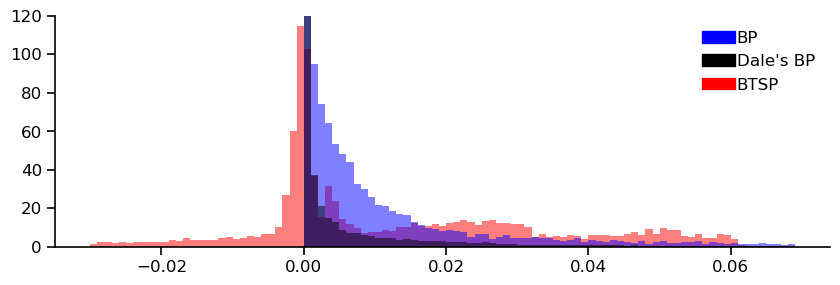

In [7]:
bins = torch.arange(-0.03,0.07,0.001)
plt.hist(dW_positive['btsp'], bins, density=True, color='r', alpha=0.5)
plt.hist(dW_positive['bp'], bins, density=True, color='b', alpha=0.5)
plt.hist(dW_positive['bpDale'], bins, density=True, color='k',alpha=0.5)

from matplotlib.patches import Circle
handles = [plt.Circle((0, 0),color='b'),plt.Circle((0, 0),color='k'),plt.Circle((0, 0),color='r')]
labels= ["BP","Dale's BP", "BTSP"]
plt.legend(handles, labels)

plt.ylim(top=120)
plt.show()

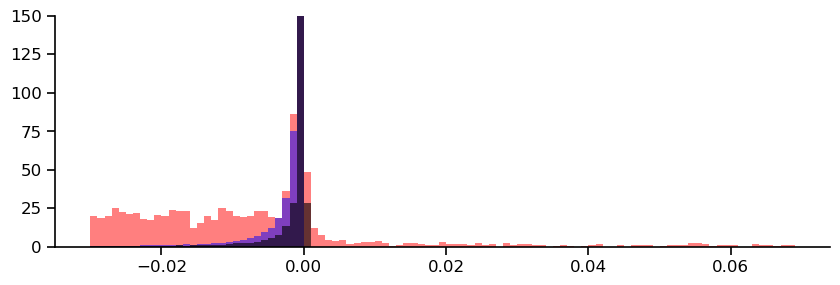

In [8]:
bins = torch.arange(-0.03,0.07,0.001)
plt.hist(dW_negative['btsp'], bins, density=True, color='r',alpha=0.5)
plt.hist(dW_negative['bp'], bins, density=True, color='b',alpha=0.5)
plt.hist(dW_negative['bpDale'], bins, density=True, color='k',alpha=0.6)

plt.ylim(top=150)
plt.show()